# Code for varying final time and amount of data points for neural ODE

In this code, we experiment with changing the simulation end points, as well as the amount of data points in the data set, to see where limits are of the neural ODE approach to inferring the GRN from data

In [1]:
import torch
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

56


check


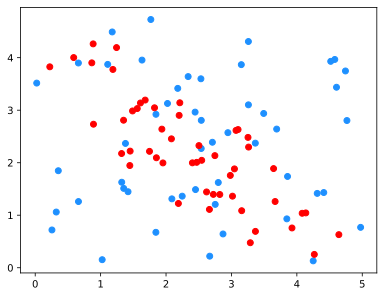

No change applied to TS or repr data


In [2]:
data_noise = 0.0
plotlim = [-0.2, 1.2]
subfolder = 'traj_TS'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('TS', noise = data_noise, plotlim = plotlim, random_state = seed, label = 'vector', deltat=0.5, batch_size=50)

In [3]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 2, 100
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = False
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'bottleneck' #outside

In [4]:
num_epochs = 500 #number of optimization runs in which the dataset is used for gradient decent
eps = 0.2

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-2)

from models.training import doublebackTrainer

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps_comp = 0.2) 
# verbose = True for more details
trainer_anode.train(dataloader, num_epochs)

c:\Data\Code\BioML\models\neural_odes.py:113: UserWarning: Extending the dynamics
  warn('Extending the dynamics')



Iteration 0/1
Loss: 1.028
Epoch 1: 1.028

Iteration 0/1
Loss: 0.892
Epoch 2: 0.892

Iteration 0/1
Loss: 0.773
Epoch 3: 0.773

Iteration 0/1
Loss: 0.671
Epoch 4: 0.671

Iteration 0/1
Loss: 0.585
Epoch 5: 0.585

Iteration 0/1
Loss: 0.514
Epoch 6: 0.514

Iteration 0/1
Loss: 0.457
Epoch 7: 0.457

Iteration 0/1
Loss: 0.412
Epoch 8: 0.412

Iteration 0/1
Loss: 0.379
Epoch 9: 0.379

Iteration 0/1
Loss: 0.356
Epoch 10: 0.356

Iteration 0/1
Loss: 0.342
Epoch 11: 0.342

Iteration 0/1
Loss: 0.335
Epoch 12: 0.335

Iteration 0/1
Loss: 0.334
Epoch 13: 0.334

Iteration 0/1
Loss: 0.336
Epoch 14: 0.336

Iteration 0/1
Loss: 0.341
Epoch 15: 0.341

Iteration 0/1
Loss: 0.346
Epoch 16: 0.346

Iteration 0/1
Loss: 0.351
Epoch 17: 0.351

Iteration 0/1
Loss: 0.354
Epoch 18: 0.354

Iteration 0/1
Loss: 0.355
Epoch 19: 0.355

Iteration 0/1
Loss: 0.354
Epoch 20: 0.354

Iteration 0/1
Loss: 0.350
Epoch 21: 0.350

Iteration 0/1
Loss: 0.345
Epoch 22: 0.345

Iteration 0/1
Loss: 0.338
Epoch 23: 0.338

Iteration 0/1
Loss:

0.01559379417449236

The adjacency matrix is given by:
tensor([[1.2917, 6.0112],
        [3.0347, 6.9820]], grad_fn=<MmBackward0>)
Gamma is given by
Parameter containing:
tensor([ 0.6662, -0.2389], requires_grad=True)
tensor([[3.0778, 4.2943]])
tensor([-8.4875,  1.6404], grad_fn=<SubBackward0>)


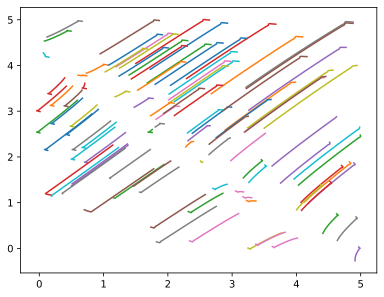

In [5]:
lv = trainer_anode.histories["loss_history"]

W1 = anode.flow.dynamics.fc1_time[0].weight
W2 = anode.flow.dynamics.fc3_time[0].weight
b1 = anode.flow.dynamics.fc1_time[0].bias
b2 = anode.flow.dynamics.fc3_time[0].bias
gam = anode.flow.dynamics.gamma[0].bias
A = torch.matmul(W1,W2)

print("The adjacency matrix is given by:")
print(A)

print("Gamma is given by")
print(gam)

# expected dynamics based on model structure
def expected_dynamics(W1,b1,W2,b2,gam,x):

    out = torch.matmul(W1,x) + b1
    out = out.detach().numpy()
    out = np.tanh(out)
    out = torch.tensor(out)
    out = torch.matmul(W2,out) + b2
    out = out - abs(gam)*x

    return out

#plt.plot(range(0,len(lv)),lv)

# make some number of initial conditions and simulate the fitted neural ODE for these trajectories
for k in range(0,100):
    x0 = torch.distributions.uniform.Uniform(0, 5).sample([1,2])

    sol = anode.flow.trajectory(x0[0],num_steps)
    sol = sol.detach().numpy()

    plt.plot(sol[:,0],sol[:,1])
    
    fw = anode.flow.dynamics.forward(0,x0[0],prnt = False)

    fw2 = expected_dynamics(W1,b1,W2,b2,gam,x0[0])

print(x0)
print(fw)


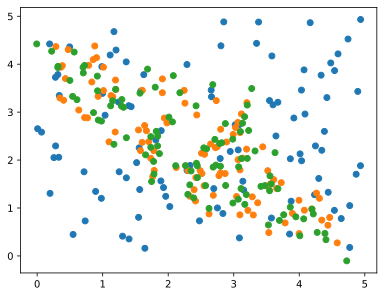

In [7]:
import scipy

batch_size = 100
size = [batch_size, 2]  # dimension of the pytorch tensor to be generated
low, high = 0, 5  # range of uniform distribution

X = torch.distributions.uniform.Uniform(low, high).sample(size)

def toggleswitch(x, t):
    gamma_x, ell_x, delta_x, theta_x = 1, 0.4, 4, 2
    gamma_y, ell_y, delta_y, theta_y = 1, 0.4, 4, 2
    
    hill_func = lambda x: ell_x + delta_x/2 * (np.tanh( theta_x - x) + 1)
            
    Gamma = np.array([gamma_x, gamma_y])
    Ell = np.array([ell_x, ell_y])
    Delta = np.array([delta_x, delta_y])
    Theta = np.array([theta_x, theta_y])
    Connection_matrix = np.array([[0, 1], [1, 0]])

    Act = Ell + np.multiply(Delta/2, np.tanh( Theta - np.matmul(Connection_matrix, x)) + 1 )
    y = Act - np.multiply(Gamma, x)
    return y


y = np.array([scipy.integrate.odeint(toggleswitch, X[i, :], [0, 0.5])[-1, :] for i in range(batch_size)])
plt.scatter(X[:,0],X[:,1])
plt.scatter(y[:,0],y[:,1])
y = anode.flow(X)
y=y.detach().numpy()
plt.scatter(y[:,0],y[:,1])
plt.show()